<a href="https://colab.research.google.com/github/AtreyaBandyopadhyay/NLP-with-Disaster-Tweets/blob/main/3_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow_text
!pip install tf-models-official

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import shutil

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [7]:
pd.options.display.max_colwidth = 100

## 1. Dataset preparation

### 1.1 Loading the dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset = pd.read_csv("/content/drive/MyDrive/Disaster Tweet Twitter/Dataset/cleaned_train.csv")

In [10]:
dataset.head()

,Unnamed: 0,id,keyword,location,text,target
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### 1.2 Adding Features to text

In [11]:
dataset["keyword"].fillna(" ",inplace=True)

In [12]:
dataset["text_with_features"]=""

for i in range(len(dataset)):
  text_with_features=dataset.loc[i,"text"]
  lastcharacter=dataset.loc[i,"text"]
  if isinstance(lastcharacter, str)==False:
    lastcharacter=str(lastcharacter)

  if isinstance(text_with_features, str)==False:
    text_with_features=str(text_with_features)


  #hashtags=dataset.loc[i,"hashtag"].replace("[","").replace("]","").replace("'","")
  if lastcharacter[-1]==".":
    text_with_features=text_with_features+dataset.loc[i,"keyword"]#+"."+hashtags
  else:
    text_with_features=text_with_features+"."+dataset.loc[i,"keyword"]#+"."+hashtags

  dataset.loc[i,"text_with_features"]=text_with_features




In [13]:
dataset.head()

,Unnamed: 0,id,keyword,location,text,target,text_with_features
0,0,1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all.
1,1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada.
2,2,5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...
3,3,6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California ."
4,4,7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school .


### 1.3 Train Validation Test Split

In [14]:
X = dataset["text_with_features"]
y = dataset["target"]

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.10, random_state=42)

In [16]:
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.10, random_state=42)

In [17]:
X_train = [sentence for sentence in X_train]
X_valid = [sentence for sentence in X_valid]

In [18]:
y_train = list(y_train)
y_valid = list(y_valid)
y_test = list(y_test)

## 2 Modelling

### 2.1 Definning call backs

In [21]:
class modelCheckPointOnF1(tf.keras.callbacks.Callback):
  best_f1 = 0
  save_path = "model_weights"


  def on_epoch_end(self, epoch, logs=None):
    precision = logs['val_precision']
    recall = logs['val_recall']
    f1_score = 2*precision*recall/(precision+recall)
    print(f" val_f1_score:{f1_score}")
    if f1_score>self.best_f1:
      self.on_epoch_endbest_f1 = f1_score
      self.model.save_weights("./model_weights")

### 2.2 Defining Model

In [27]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.4)(net)
  net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [23]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall")]

In [24]:
epochs = 80
batch_size = 32
steps_per_epoch =  len(X_train)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### 2.3 Training Model

In [33]:
history = classifier_model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=epochs,callbacks=[modelCheckPointOnF1()])

Epoch 1/80
177/177 [==============================] - 46s 149ms/step - loss: 0.7242 - binary_accuracy: 0.5657 - precision: 0.4719 - recall: 0.4886 - val_loss: 0.6251 - val_binary_accuracy: 0.6656 - val_precision: 0.6597 - val_recall: 0.3711
Epoch 2/80
177/177 [==============================] - 24s 136ms/step - loss: 0.7127 - binary_accuracy: 0.5810 - precision: 0.4879 - recall: 0.4273 - val_loss: 0.6008 - val_binary_accuracy: 0.6927 - val_precision: 0.7520 - val_recall: 0.3672
Epoch 3/80
177/177 [==============================] - 24s 133ms/step - loss: 0.6728 - binary_accuracy: 0.6165 - precision: 0.5380 - recall: 0.4644 - val_loss: 0.5743 - val_binary_accuracy: 0.7150 - val_precision: 0.7655 - val_recall: 0.4336
Epoch 4/80
177/177 [==============================] - 26s 148ms/step - loss: 0.6391 - binary_accuracy: 0.6535 - precision: 0.5954 - recall: 0.4860 - val_loss: 0.5452 - val_binary_accuracy: 0.7357 - val_precision: 0.7446 - val_recall: 0.5352
Epoch 5/80
177/177 [================

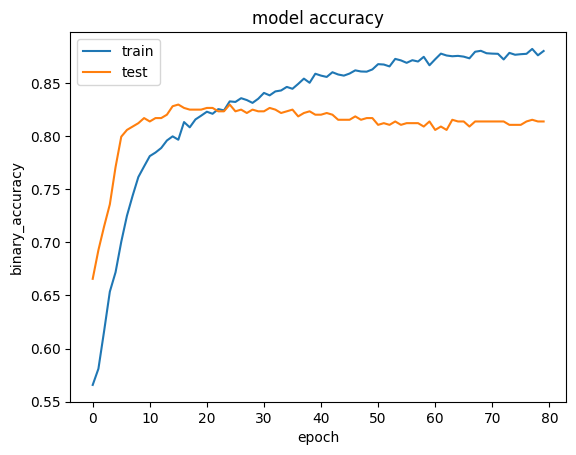

In [34]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

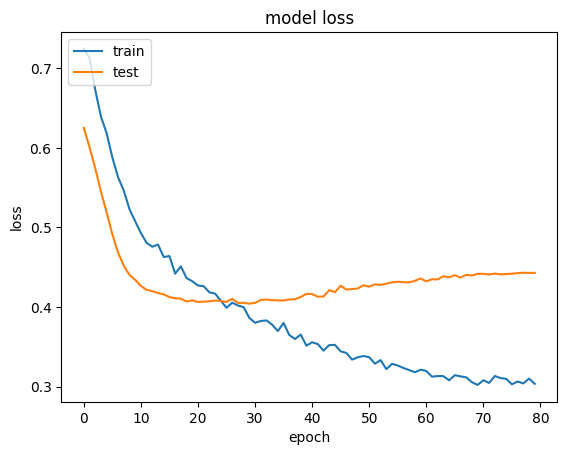

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Evaluation

In [ ]:
classifier_model.load_weights("model_weights.index")

In [37]:
y_train_pred = classifier_model.predict(X_train)
y_valid_pred = classifier_model.predict(X_valid)
y_test_pred = classifier_model.predict(X_test)

22/22 [==============================] - 2s 71ms/step


In [38]:
y_train_pred = np.where(y_train_pred>.5,1,0)
y_valid_pred = np.where(y_valid_pred>.5,1,0)
y_test_pred = np.where(y_test_pred>.5,1,0)

In [39]:
#train metrics
print(f1_score(y_train,y_train_pred))
print(accuracy_score(y_train,y_train_pred))

0.8828748890860693
0.9065652096973987


In [40]:
#validation metrics
print(f1_score(y_valid,y_valid_pred))
print(accuracy_score(y_valid,y_valid_pred))

0.7701375245579567
0.8136942675159236


In [41]:
#test metrics
print(f1_score(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))

0.74822695035461
0.7965616045845272
